# EDA – Starting the Hull Tactical S&P500 Preds 💸

This analysis aims to explore the dataset and clarify the objectives of the **Hull Tactical Market Prediction** competition.

Never forget the main goal :  

🎯 "To build a model that predicts excess returns and includes a betting strategy designed to outperform the S&P 500 while staying within a 120% volatility constraint."

**References:**
- [Competition page](https://www.kaggle.com/competitions/hull-tactical-market-prediction)  
- [EDA notebook by ambrosm](https://www.kaggle.com/code/ambrosm/htmp-eda-which-makes-sense/notebook)


In [83]:
import numpy as np
import pandas as pd

from plotnine import ggplot, aes, geom_line, geom_boxplot, geom_histogram, theme_classic
from plotnine import labs, options, theme, element_line, element_text, annotate, geom_vline

options.figure_size = (10, 5) 

def my_theme_classic(base_size=11, base_family=None):
    return theme_classic(base_size=base_size, base_family=base_family) + theme(
        panel_grid_major_y=element_line(color="gray", size=1, alpha=0.2),
        plot_title=element_text(face="bold")
    )




In [84]:
import os

# Kaggle définit automatiquement la variable d'environnement KAGGLE_URL_BASE
ON_KAGGLE = "KAGGLE_URL_BASE" in os.environ

if ON_KAGGLE:
    DATA_PATH = "/kaggle/input/hull-tactical-market-prediction/"
else:
    DATA_PATH = "../data/raw/"



df_train = pd.read_csv(os.path.join(DATA_PATH, "train.csv")).sort_values("date_id")
df_test = pd.read_csv(os.path.join(DATA_PATH, "test.csv")).sort_values("date_id")

df_plot = df_train.copy()

# 1 - Understand the main columns 🤓  

Let's take a closer look at the key variables:  

- **forward_returns**: The returns from buying the S&P 500 and selling it a day later. *(Train set only.)*  

- **risk_free_rate**: The federal funds rate. *(Train set only.)*  

- **market_forward_excess_returns**: Forward returns relative to expectations. Computed by subtracting the rolling five-year mean forward returns and winsorizing the result using a median absolute deviation (MAD) with a criterion of 4. *(Train set only.)*  


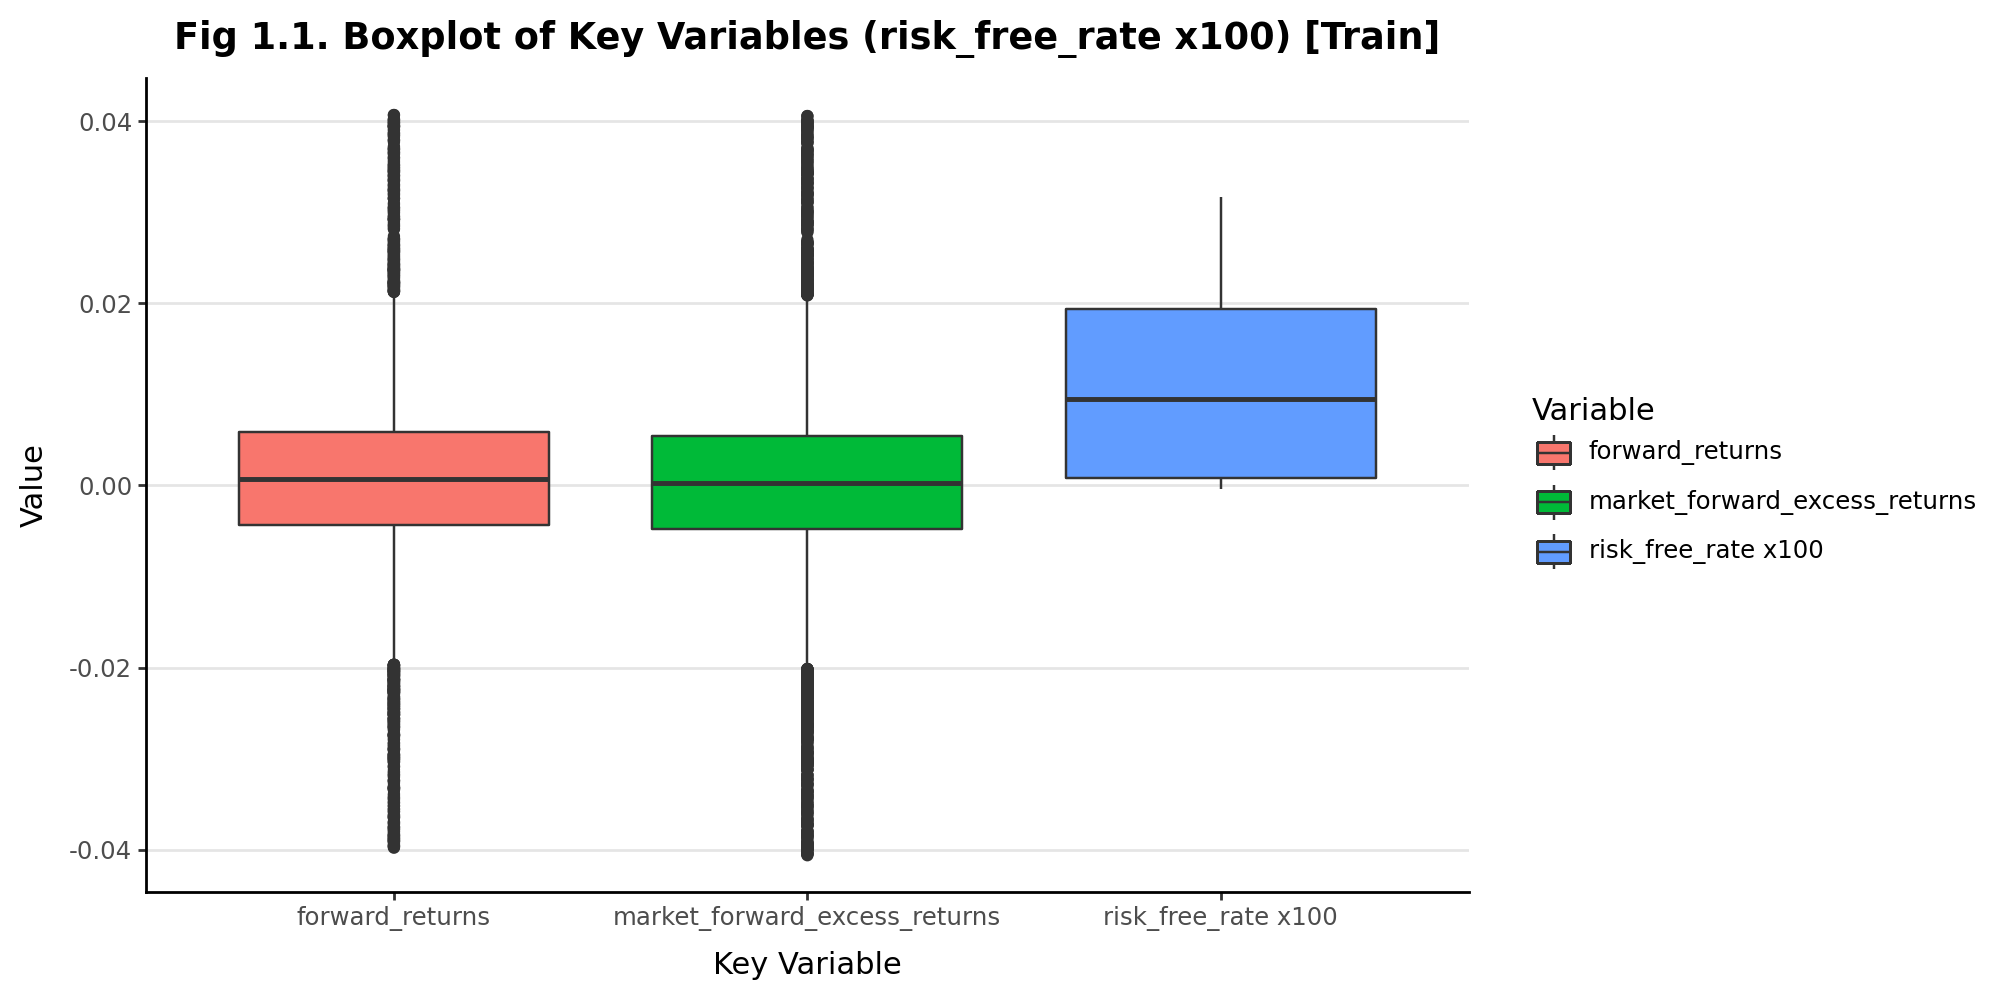

In [85]:
# Colonnes à comparer
cols = ['forward_returns', 'risk_free_rate', 'market_forward_excess_returns']

# Copier le DataFrame pour ne pas modifier l'original
df_boxplot = df_plot[cols].copy()


# Appliquer la transformation
df_boxplot['risk_free_rate'] = df_boxplot['risk_free_rate'] * 100
df_boxplot.rename(columns={'risk_free_rate': 'risk_free_rate x100'}, inplace=True)

# Transformer en format long
df_long = df_boxplot.melt(var_name='Variable', value_name='Value')

# Créer le boxplot
box_plot = (
    ggplot(df_long, aes(x='Variable', y='Value', fill='Variable'))
    + geom_boxplot()
    + labs(
        title="Fig 1.1. Boxplot of Key Variables (risk_free_rate x100) [Train]",
        x="Key Variable",
        y="Value"
    )
    + my_theme_classic()
)

box_plot


### 1.1 - Forward Returns 🎢

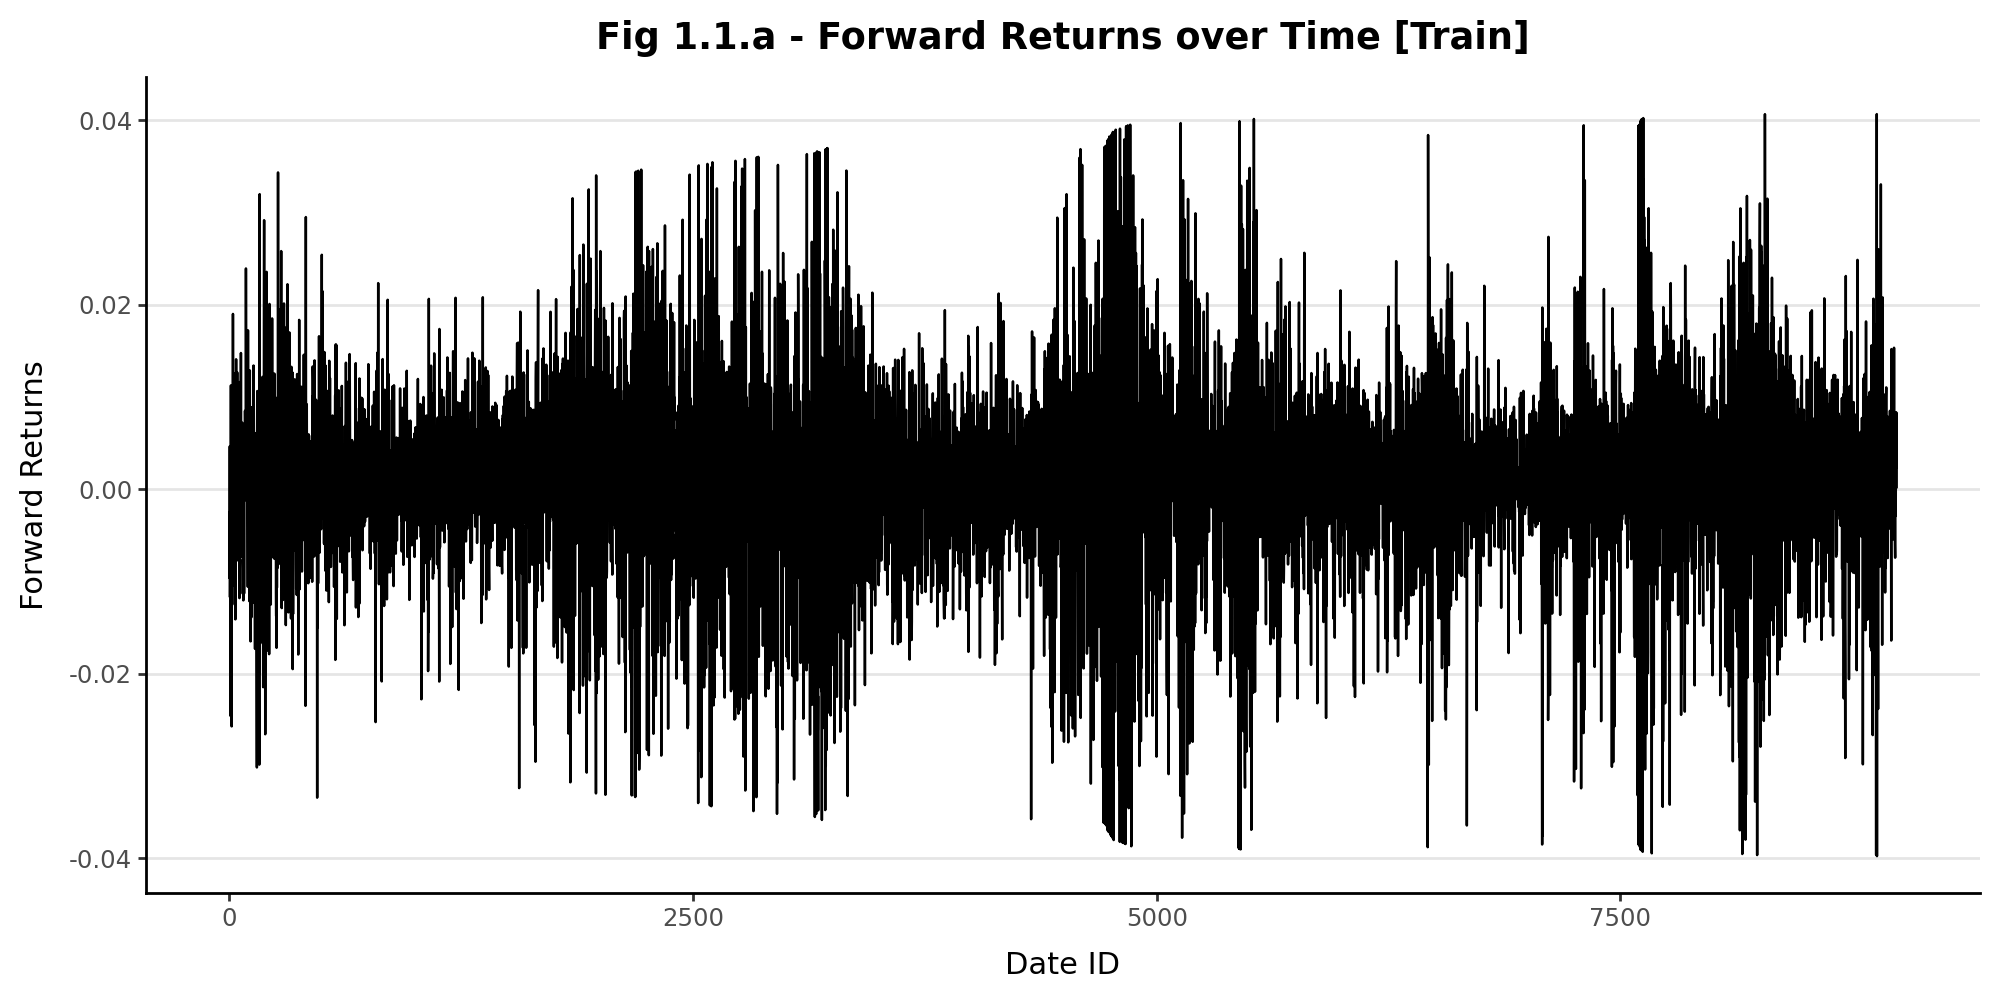

In [86]:
plot = (
    ggplot(df_plot, aes(x="date_id", y=df_plot["forward_returns"]))
    + geom_line()
    + labs(
        title="Fig 1.1.a - Forward Returns over Time [Train]",
        x="Date ID",
        y="Forward Returns"
    )
    + my_theme_classic()
)

plot

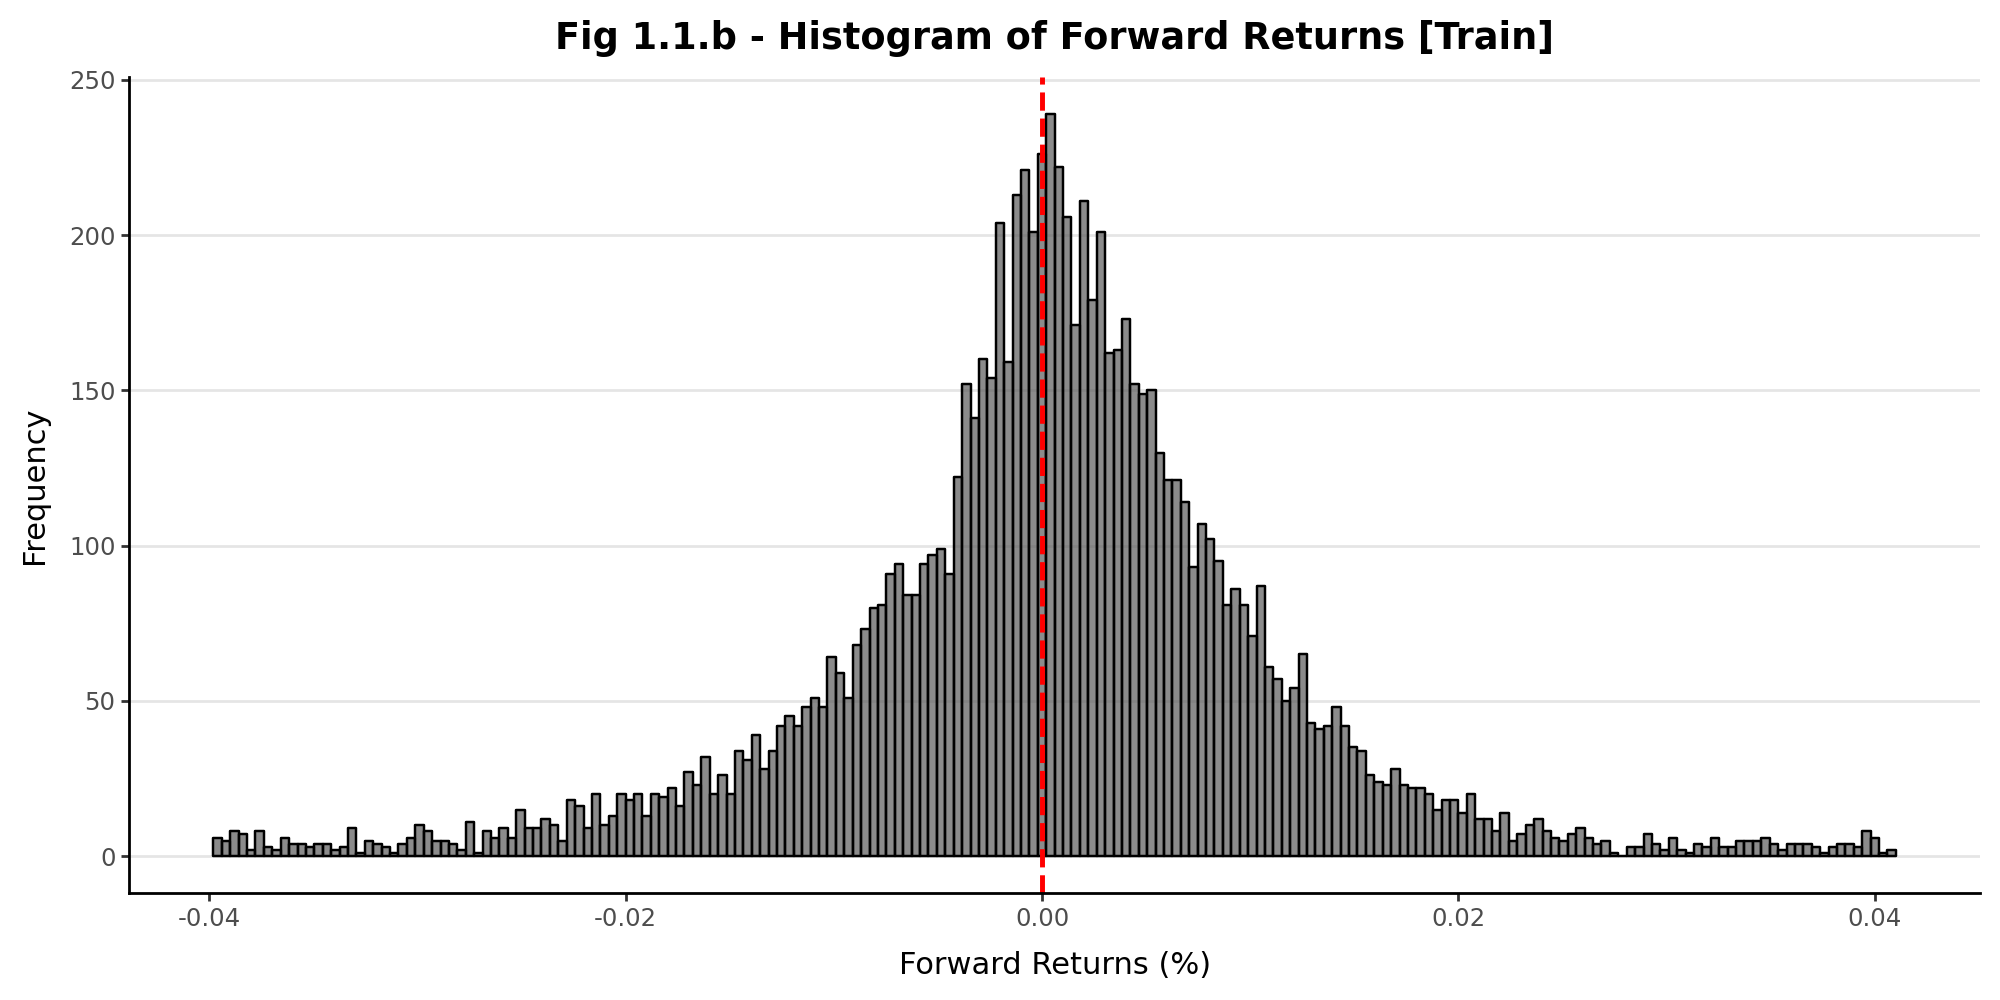

In [87]:
# Histogramme
hist_plot = (
    ggplot(df_plot, aes(x='forward_returns'))
    + geom_histogram(bins=200, color='black', alpha=0.7)
    + geom_vline(xintercept=0, color='red', linetype='dashed', size=1)  # ligne verticale
    + labs(
        title="Fig 1.1.b - Histogram of Forward Returns [Train]",
        x="Forward Returns (%)",
        y="Frequency"
    )
    + my_theme_classic()
)

hist_plot



The **Fig 1.1** shows that forward returns are always between -4 % and +4 %.

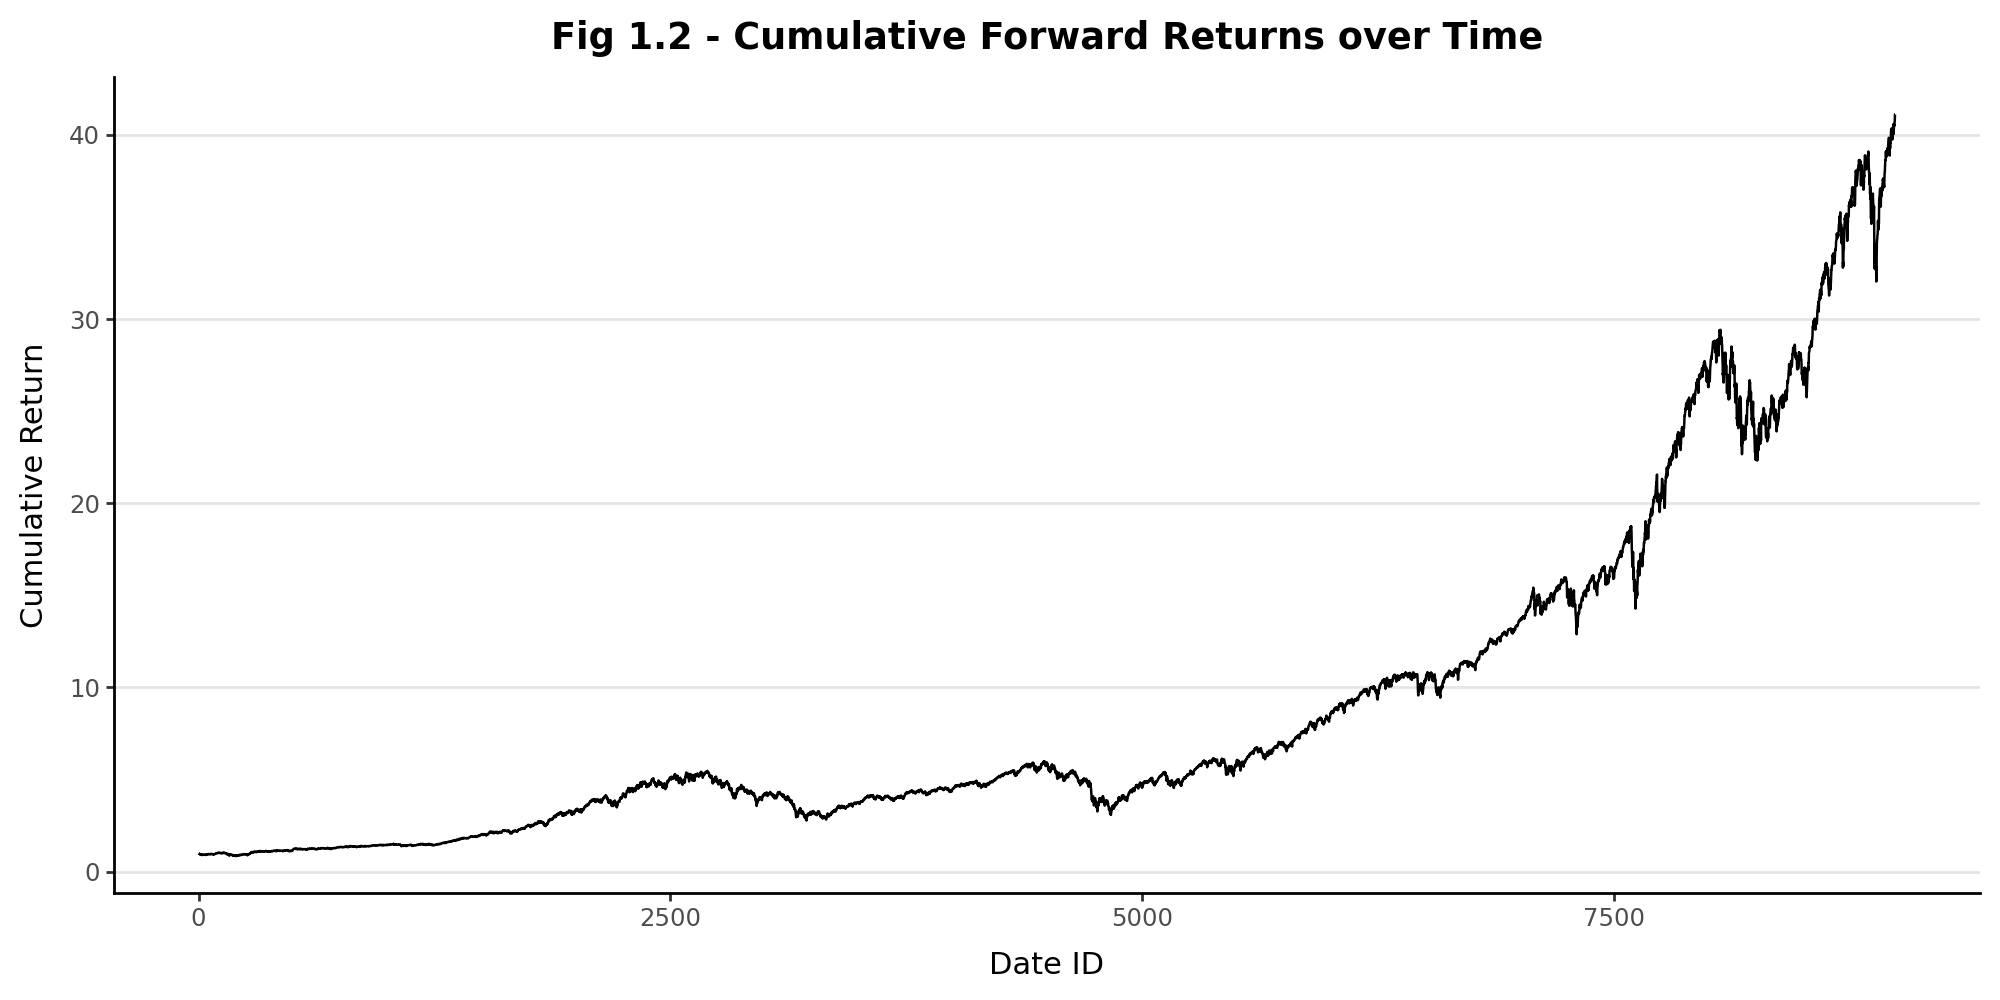

In [88]:
df_plot["cumulative_return"] = (1 + df_plot["forward_returns"]).cumprod()

plot = (
    ggplot(df_plot, aes(x="date_id", y="cumulative_return"))
    + geom_line()
    + labs(
        title="Fig 1.2 - Cumulative Forward Returns over Time",
        x="Date ID",
        y="Cumulative Return"
    )
    + my_theme_classic()
)

plot

### 1.2 - Risk Free rate 🛡️

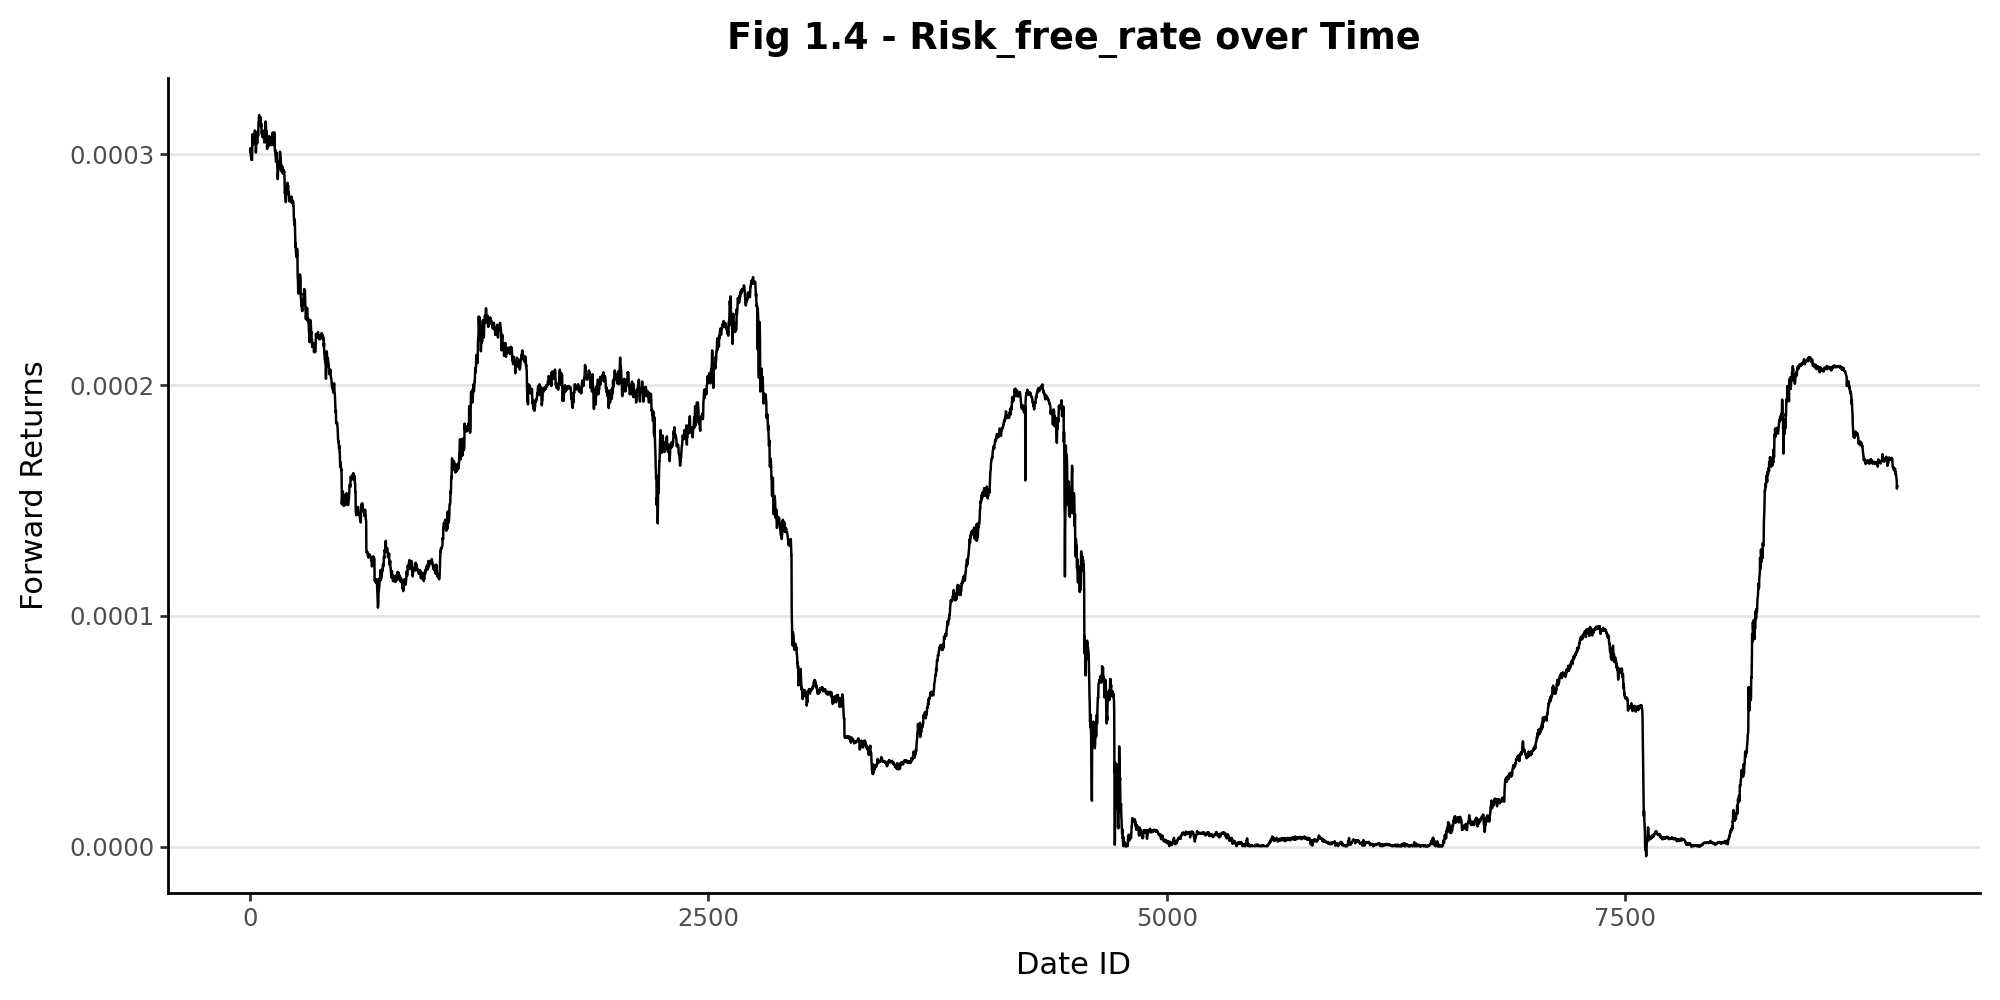

In [89]:
plot = (
    ggplot(df_plot, aes(x="date_id", y="risk_free_rate"))
    + geom_line()
    + labs(
        title="Fig 1.4 - Risk_free_rate over Time",
        x="Date ID",
        y="Forward Returns"
    )
    + my_theme_classic()
)

plot

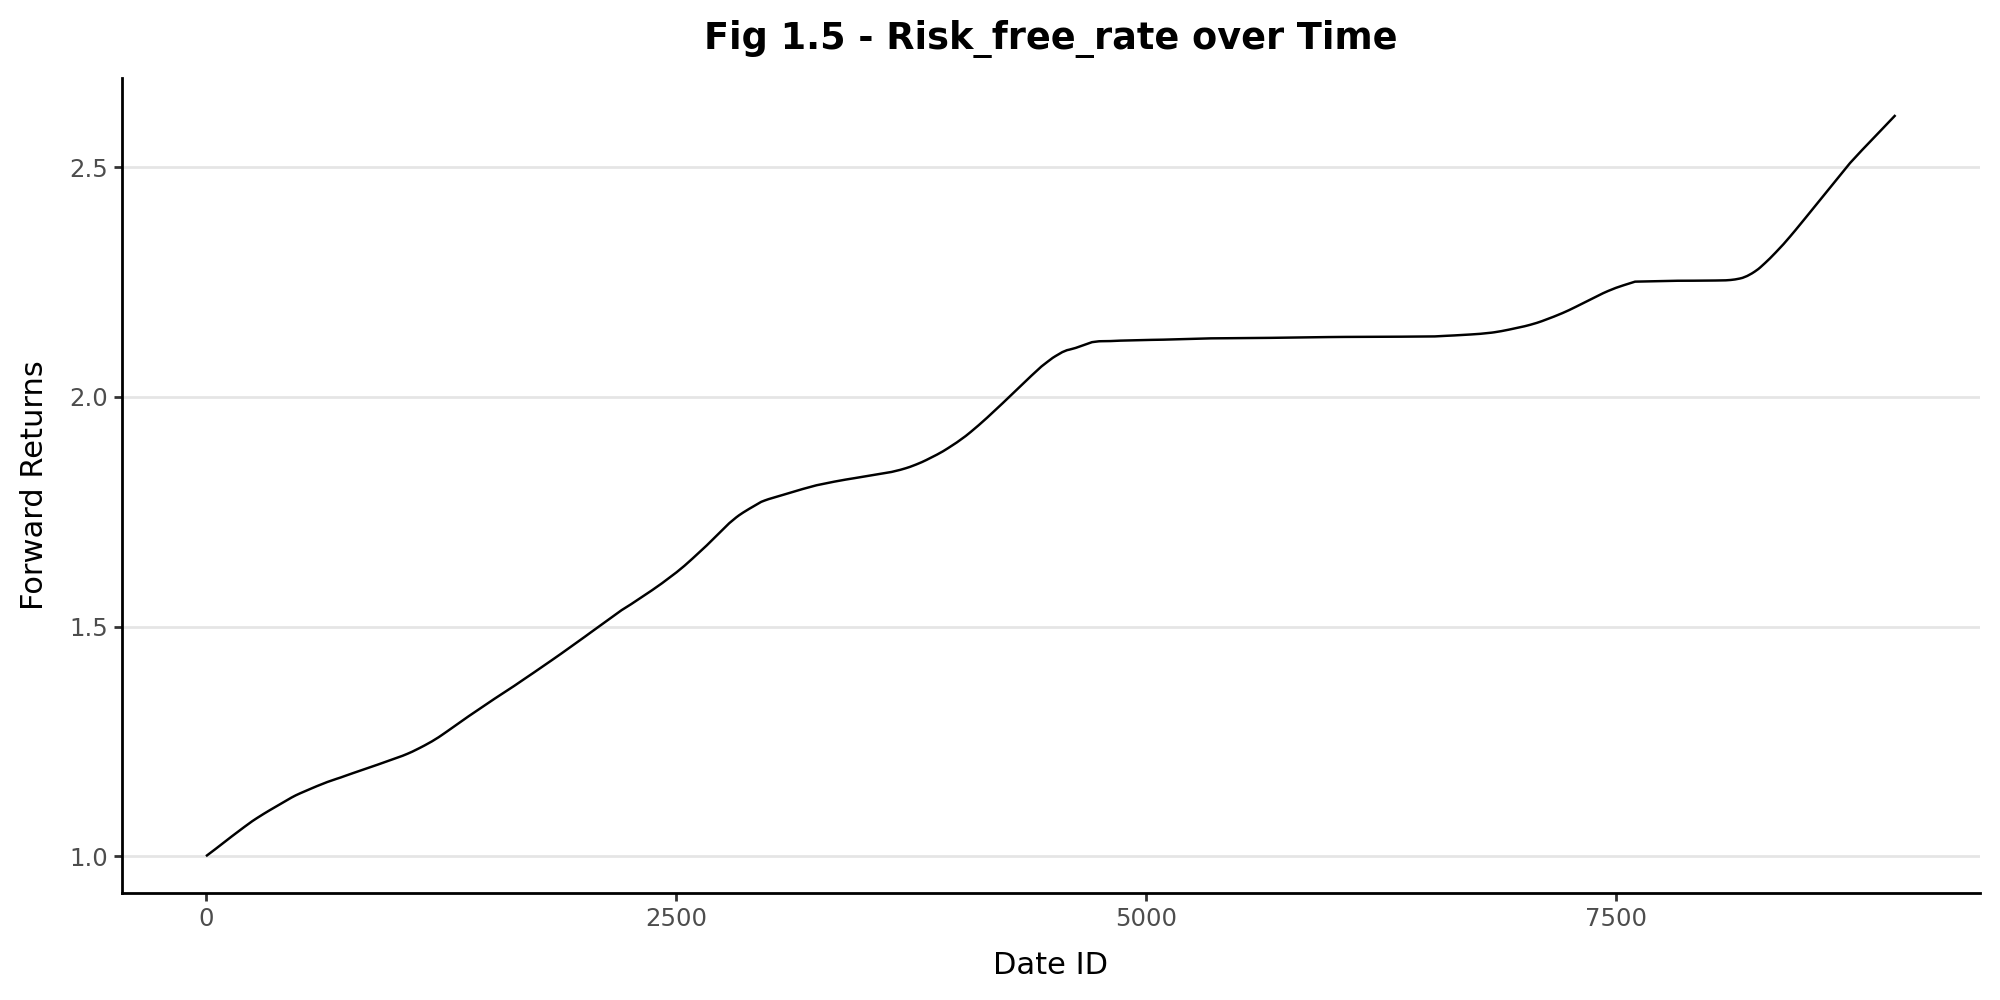

In [90]:
df_plot["cumulative_risk_free_rate"] = (1 + df_plot["risk_free_rate"]).cumprod()
plot = (
    ggplot(df_plot, aes(x="date_id", y="cumulative_risk_free_rate"))
    + geom_line()
    + labs(
        title="Fig 1.5 - Risk_free_rate over Time",
        x="Date ID",
        y="Forward Returns"
    )
    + my_theme_classic()
)
plot

### 1.3 - Market Forward Excess Returns 🎰

**Definition**  
Forward returns **relative to expectations** — computed by subtracting the rolling five-year mean forward returns, then *winsorizing* the result to reduce the impact of extreme values. Winsorization is performed using the Median Absolute Deviation (MAD) with a threshold of 4. **Available only in the training set.**

**Formula (conceptual)**  
- Let $R_t$ be the forward return at time $t$.  
- Let $\mu_t^{(5y)}$ be the 5-year rolling mean of $R$ at time $t$.  
- Compute the relative deviation:  
  $D_t = R_t - \mu_t^{(5y)}$
- Winsorize $D_t$ by bounding extreme values using MAD:  
  $\text{MAD} = \operatorname{median}(|D_t - \operatorname{median}(D)|)$  
  Bounds = $\operatorname{median}(D) \pm 4 \times \text{MAD}$.  
  Values outside these bounds are replaced by the nearest bound.

#### 1.3.a - Calculate Myself the Market Forward Excess Returns


In [111]:
# Copier le DataFrame pour le plot
df_plot = df_mfer.copy()

# Cumulative product pour performance cumulative
df_plot['cum_R_t'] = (1 + df_plot['forward_returns']).cumprod()
df_plot['cum_mu_5years'] = (1 + df_plot['forward_returns'].rolling(window=1250, min_periods=1).mean()).cumprod()

# Déviation cumulative
df_plot['D_t'] = df_plot['cum_R_t'] - df_plot['cum_mu_5years']

# Winsorization sur D_t
median_D = df_plot['D_t'].median()
MAD = np.median(np.abs(df_plot['D_t'] - median_D))
lower_bound = median_D - 4 * MAD
upper_bound = median_D + 4 * MAD
df_plot['market_forward_excess_returns_pred'] = df_plot['D_t'].clip(lower=lower_bound, upper=upper_bound)

# Vérification rapide
print('My Pred is equal to D_t:', (df_plot['market_forward_excess_returns_pred'] == df_plot['D_t']).all())


My Pred is equal to D_t: False


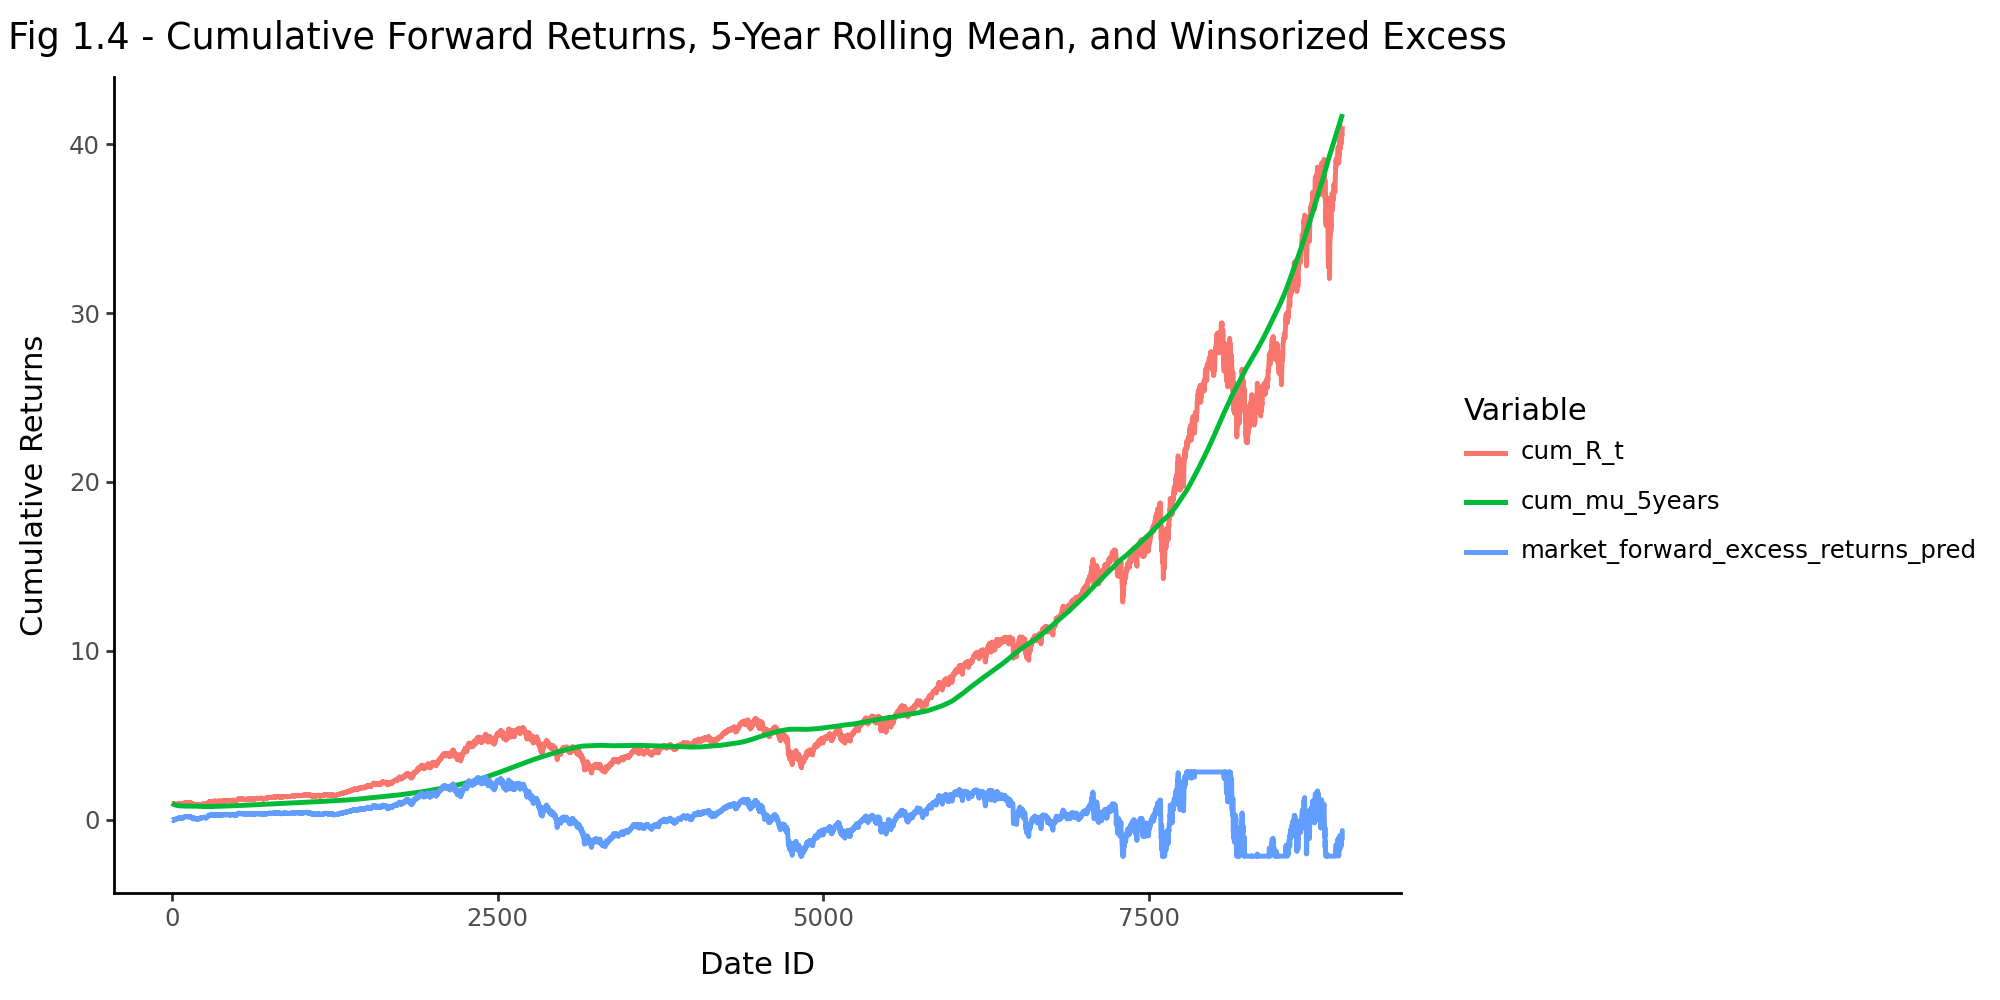

In [117]:
from plotnine import ggplot, aes, geom_line, labs, theme_classic

# Reshape pour plot avec couleurs
df_long = df_plot.melt(
    id_vars=["date_id"],
    value_vars=["cum_R_t", "cum_mu_5years", "market_forward_excess_returns_pred"],
    var_name="Variable",
    value_name="Cumulative Return"
)

plot = (
    ggplot(df_long, aes(x="date_id", y="Cumulative Return", color="Variable"))
    + geom_line(size=1)
    + labs(
        title="Fig 1.4 - Cumulative Forward Returns, 5-Year Rolling Mean, and Winsorized Excess",
        x="Date ID",
        y="Cumulative Returns"
    )
    + theme_classic()
)

plot

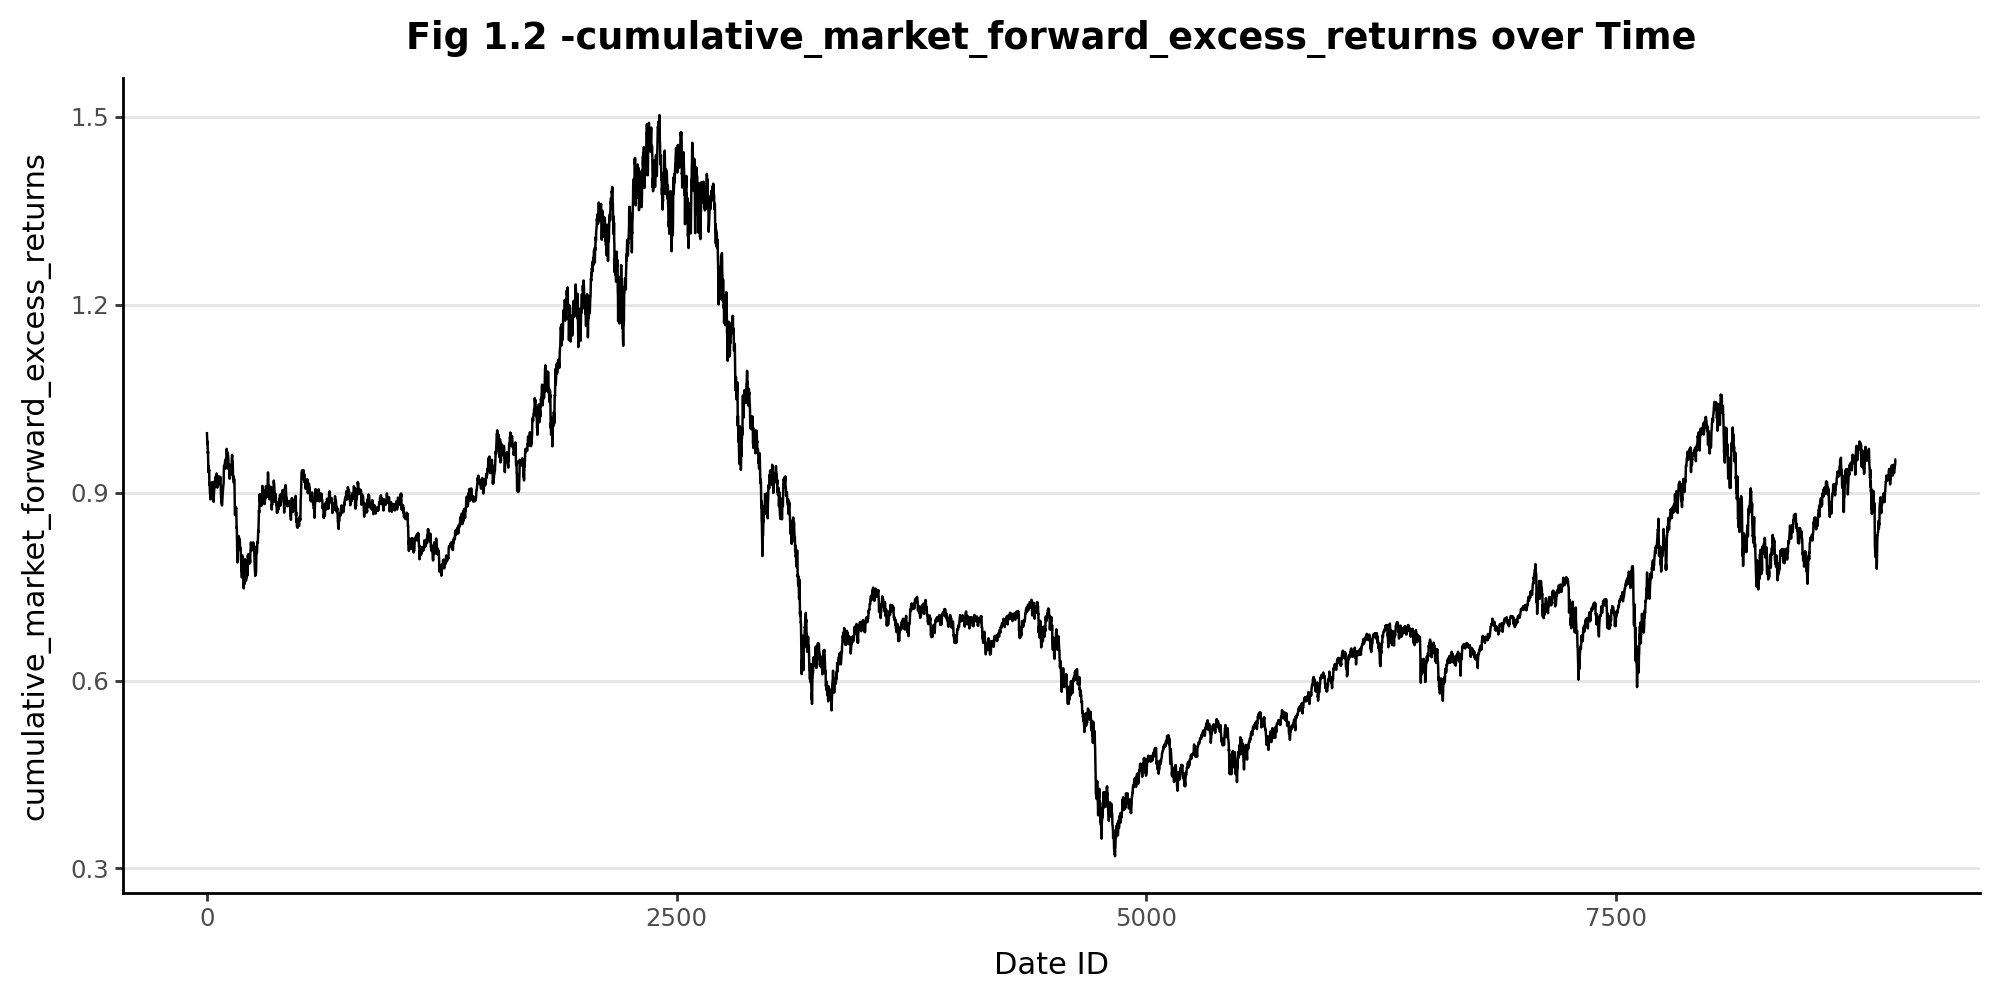

In [ ]:
df_plot["cumulative_market_forward_excess_returns"] = (1 + df_train["market_forward_excess_returns"]).cumprod()

plot = (
    ggplot(df_plot, aes(x="date_id", y="cumulative_market_forward_excess_returns"))
    + geom_line()
    + labs(
        title="Fig 1.2 -cumulative_market_forward_excess_returns over Time",
        x="Date ID",
        y="cumulative_market_forward_excess_returns"
    )
    + my_theme_classic()
)

plot

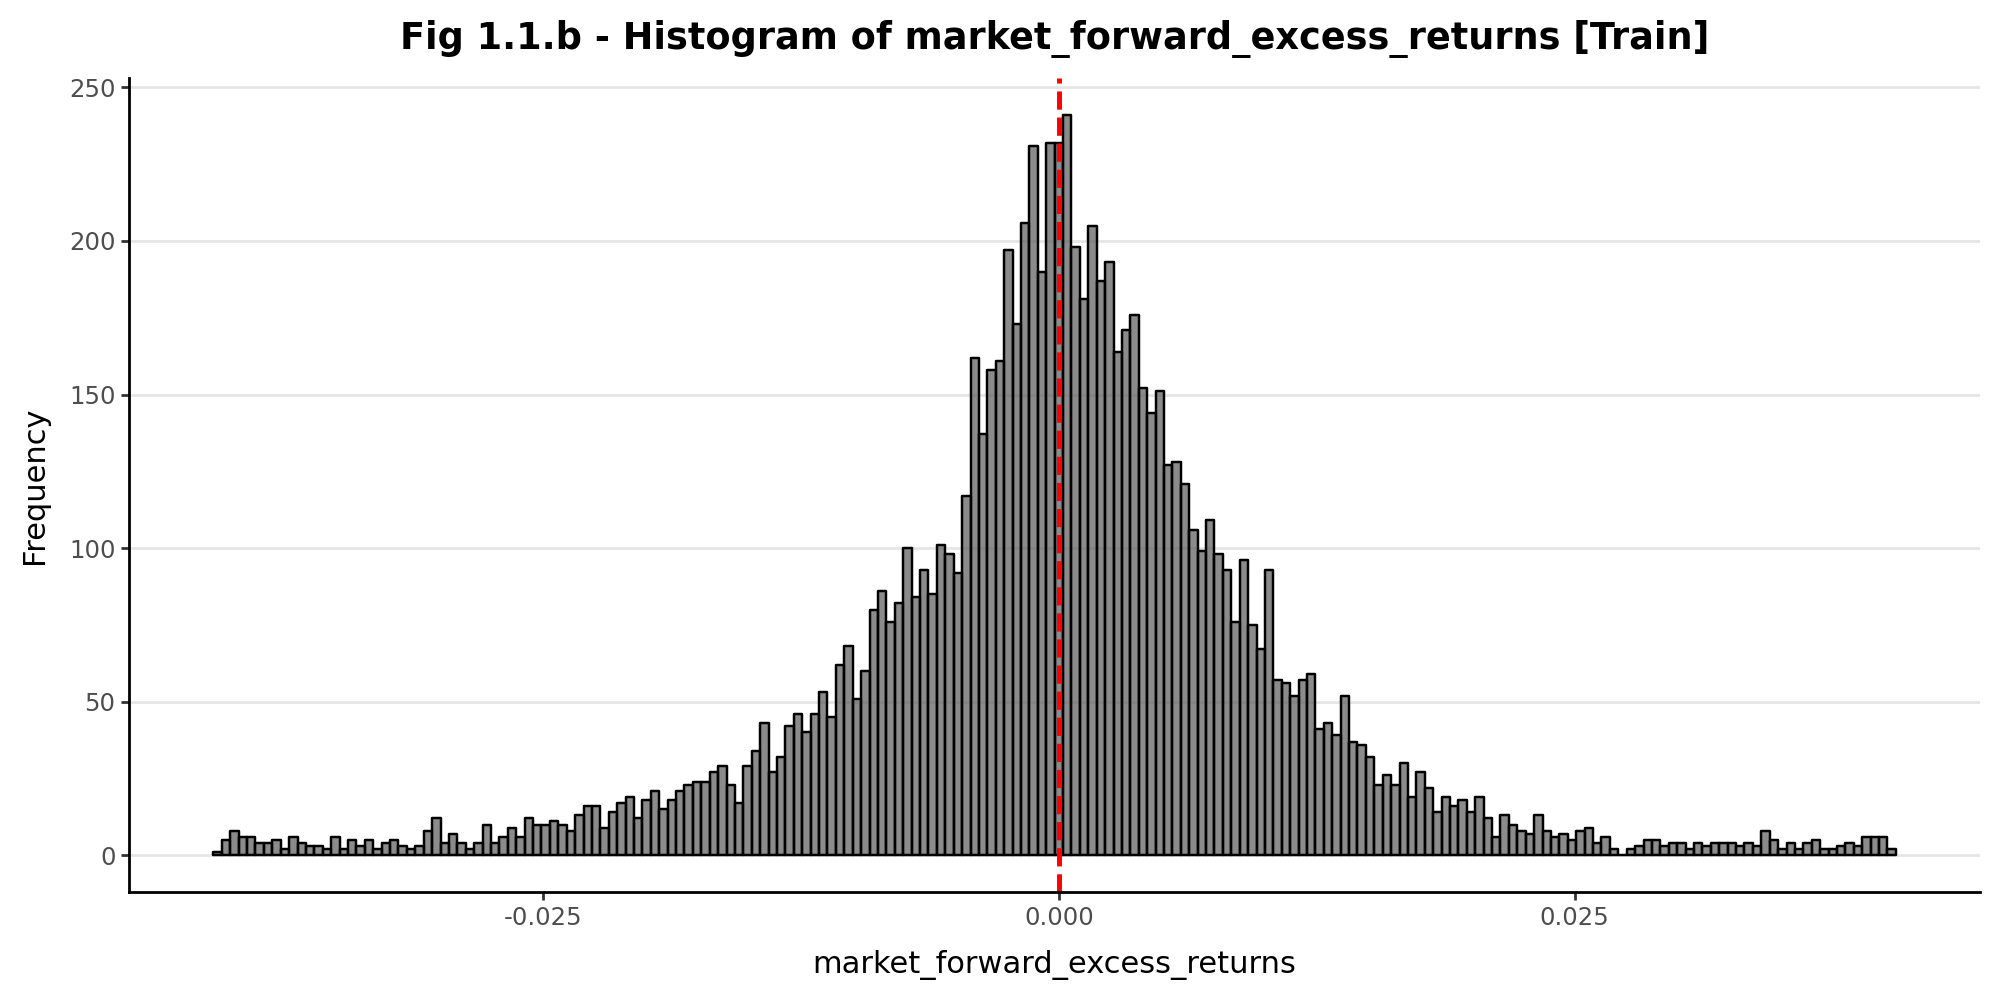

In [ ]:
# Histogramme
hist_plot = (
    ggplot(df_plot, aes(x='market_forward_excess_returns'))
    + geom_histogram(bins=200, color='black', alpha=0.7)
    + geom_vline(xintercept=0, color='red', linetype='dashed', size=1)  # ligne verticale
    + labs(
        title="Fig 1.1.b - Histogram of market_forward_excess_returns [Train]",
        x="market_forward_excess_returns",
        y="Frequency"
    )
    + my_theme_classic()
)

hist_plot



## 2 - Other features 🧩


### 2.1 - (M*) Market Dynamics/Technical features. 👩‍🏫

In [ ]:
m_features = [
    "M1","M2","M3","M4","M5","M6","M7","M8","M9",
    "M10","M11","M12","M13","M14","M15","M16","M17","M18"
]

df_train[m_features]

,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11,M12,M13,M14,M15,M16,M17,M18
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8985,-1.190313,-0.632252,1.138825,0.152280,1.359579,-0.187969,-0.571545,0.731812,0.331379,-0.262267,-0.253930,0.189556,-1.200115,-0.755640,0.676587,0.806217,0.286045,0.317130
8986,-1.218842,-0.418564,2.620436,0.097712,0.909058,-0.155919,-0.571308,0.772817,0.341697,-0.288451,-0.209835,0.138043,-1.193898,-0.754397,0.691138,0.814815,0.284722,0.316799
8987,-1.234393,0.501880,0.950040,0.061329,1.428299,-0.277512,-0.571071,0.854167,0.355097,-0.292948,-0.140272,0.166052,-1.208305,-0.754255,0.700728,0.667989,0.279762,0.316468
8988,-1.297210,-0.222224,0.948951,-0.006532,1.518843,-0.171653,-0.570834,0.773810,0.370644,-0.302140,-0.116334,0.167373,-1.214693,-0.753453,0.718585,0.541667,0.282077,0.316138


### 2.2 - (E*) Macro Economic features. 👨‍💼

In [ ]:
e_features = [
    "E1","E2","E3","E4","E5","E6","E7","E8","E9","E10",
    "E11","E12","E13","E14","E15","E16","E17","E18","E19","E20"
]
df_train[m_features]


,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11,M12,M13,M14,M15,M16,M17,M18
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8985,-1.190313,-0.632252,1.138825,0.152280,1.359579,-0.187969,-0.571545,0.731812,0.331379,-0.262267,-0.253930,0.189556,-1.200115,-0.755640,0.676587,0.806217,0.286045,0.317130
8986,-1.218842,-0.418564,2.620436,0.097712,0.909058,-0.155919,-0.571308,0.772817,0.341697,-0.288451,-0.209835,0.138043,-1.193898,-0.754397,0.691138,0.814815,0.284722,0.316799
8987,-1.234393,0.501880,0.950040,0.061329,1.428299,-0.277512,-0.571071,0.854167,0.355097,-0.292948,-0.140272,0.166052,-1.208305,-0.754255,0.700728,0.667989,0.279762,0.316468
8988,-1.297210,-0.222224,0.948951,-0.006532,1.518843,-0.171653,-0.570834,0.773810,0.370644,-0.302140,-0.116334,0.167373,-1.214693,-0.753453,0.718585,0.541667,0.282077,0.316138


### 2.3 - (I*) Interest Rate features. 👩‍⚖️

In [ ]:
i_features = [
    "I1","I2","I3","I4","I5","I6","I7","I8","I9"
]
df_train[i_features]


,I1,I2,I3,I4,I5,I6,I7,I8,I9
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
8985,0.274140,0.984115,0.080688,0.476521,0.597442,0.718254,0.238757,0.351852,0.596270
8986,0.269841,0.904453,0.073413,0.479167,0.605079,0.718254,0.220899,0.345238,0.602393
8987,0.273148,0.842295,0.074074,0.478836,0.611319,0.724868,0.223545,0.340608,0.601728
8988,0.272817,0.858582,0.082011,0.478505,0.604658,0.719577,0.262566,0.353836,0.606669


### 2.4 - (P*) Price/Valuation features. 🕴️

In [ ]:
p_features = [
    "P1","P2","P3","P4","P5","P6","P7","P8","P9",
    "P10","P11","P12","P13"
]
df_train[p_features]


,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8985,0.394180,-1.354498,0.046296,0.514550,0.276769,-0.261326,0.811754,1.784929,0.039683,2.087888,2.212791,0.648069,0.625331
8986,0.383598,-1.384785,0.232143,0.379299,1.199260,-0.344274,0.690323,1.791596,0.037037,2.092041,2.225902,0.916799,0.739418
8987,0.304894,-1.420007,0.849868,0.375661,0.429471,-0.233374,-0.289766,1.792816,0.041005,2.092283,2.235097,-0.702456,0.809193
8988,0.354828,-1.431028,0.303241,0.068783,0.044888,-0.269862,0.423268,1.792934,0.046958,2.094798,2.247297,1.456942,0.923611


### 2.5 - (V*) Volatility features. 🚣

In [ ]:
v_features = [
    "V1","V2","V3","V4","V5","V6","V7","V8","V9",
    "V10","V11","V12","V13"
]
df_train[v_features]


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8985,0.498677,0.785053,0.469577,0.837963,1.226772,0.822751,-0.707361,0.142857,-0.649616,-0.616395,0.561839,0.533730,-0.432282
8986,0.528439,0.767857,0.671958,0.837963,0.785877,0.805556,-0.715692,0.196098,-0.668289,-0.642040,0.587632,0.526455,-0.429506
8987,0.599206,0.734127,0.481481,0.787698,0.834898,0.823413,-0.723949,0.133929,-0.670946,-0.638658,0.394841,0.433532,-0.425462
8988,0.462302,0.695106,0.655423,0.783730,0.994026,0.851852,-0.684937,0.101852,-0.646265,-0.626927,0.326389,0.394180,-0.385170


### 2.6 - (S*) Sentiment features. 💑

In [ ]:
s_features = [
    "S1","S2","S3","S4","S5","S6","S7","S8","S9",
    "S10","S11","S12"
]
df_train[s_features]

,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
8985,0.249933,-0.446682,-0.052686,0.083995,0.055282,0.209656,0.409392,0.574661,0.748677,0.273148,0.134921,0.634465
8986,0.298533,-0.118050,-0.249315,0.566799,0.107330,0.228175,0.409392,0.580932,0.370370,0.933201,0.721561,1.211345
8987,0.371362,-0.316882,-0.422374,0.631614,-0.029770,0.221892,0.409392,0.583556,0.477513,0.793651,0.689815,0.885178
8988,0.411610,-0.317961,-0.608348,0.066138,-0.001594,0.259921,0.409392,0.630090,0.915344,0.011905,0.026455,-0.001785


### 2.7 - (MOM*) Momentum features. 👨‍🦯

### 2.8 - (D*) Dummy/Binary features. 👩‍💻

In [ ]:
d_features = [
    "D1","D2","D3","D4","D5","D6","D7","D8","D9"
]
df_train[d_features]

,D1,D2,D3,D4,D5,D6,D7,D8,D9
0,0,0,0,1,1,0,0,0,1
1,0,0,0,1,1,0,0,0,1
2,0,0,0,1,0,0,0,0,1
3,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
8985,0,0,0,0,0,0,0,0,0
8986,0,0,0,0,0,0,0,0,0
8987,0,0,1,0,0,0,0,0,0
8988,0,0,0,0,0,0,0,0,0
